# Recommender Systems
### Reverse-engeneering users needs/desires

Recommender systems have been in the heart of ML. Mostly that in order to get insigths on large populations it was necessary to understand how users behave, but this can only be done from the historical behaviour. 

Let's fix some setting that we use for the workshop. We have three main components: the business, the users, and the products. Most of the time a business would like to recommend products to its users. The business knows that the better it understands the user, the better the recommendations, and thus the user will be more likely to consume its products.

Simple right? Well, not as much, the following things need to be considered:

- What does it mean to know a user? How can we encode this? 
- If we have the purchase history of the user, do we want to recommend new items or old items? Why?
- Business rules exists, like inventory, push products, maximize revenue, lower churn, etc.
- What policies should be put in place? GDPR? 
- How to reduce bias.
- Computational resources, speed.
- Cold start for products and users.
- Legacy systems.
- UX integration.
- etc


Historically, two main approaches exist: collaborative filtering and content-based recommendations. These are often used together.

# Collaborative Filtering


## Memory based

 - Easy to explain
 - Hard to scale
 - Not good for sparse data

Usually based on similarity. 




## Model based

 - Good for sparse
 - Difficult to explain
 - Hard to do inference


Let's start with the most basic approach using a popular
(light-weight) dataset [MovieLens](http://files.grouplens.org/datasets/movielens/ml-20m.zip)

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load MovieLens Data

In [3]:
data_dir = "../data/ml-20m"

os.listdir(data_dir)

['movies.csv', 'ratings.csv']

In [4]:
movies = pd.read_csv(f"{data_dir}/movies.csv")
ratings = pd.read_csv(f"{data_dir}/ratings.csv")

## Exploring the data 

Use pandas to understand the distribution of your data, this helps understand what kind of goals are possible. It is always a good idea to extensively explore and understand the data.

### Exercise:
1. Choose a couple from the following list and use pandas to find out the answer:

    - What columns exist in the data?
    - What are the possible rankings?
    - How are the rankings distributed? 
    - What is the average ranking? 
    - What is the distribution of the average ranking among users?
    - How many genres are there?
    - What is the genre distribution for the movies?
    - What can you say about the timestamp? 
    - Do all movies have a year? What is the distribution of Mystery movies during the years?

2. Come up with at least two more statistics that aren't from the above list.

*Use the following couple of cells to answer your questions. Make sure to work on this before moving ahead.*

In [5]:
# What columns exist in the data?
print(f"The movies dataset has columns: {movies.columns.values}")
print(f"The ratings dataset has columns: {ratings.columns.values}")

The movies dataset has columns: ['movieId' 'title' 'genres']
The ratings dataset has columns: ['userId' 'movieId' 'rating' 'timestamp']


In [6]:
# What are the possible rankings?
sorted(ratings.rating.unique())

[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

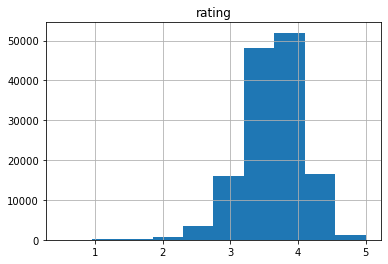

In [7]:
# How are the rankings distributed?
ratings[['userId', 'rating']].groupby('userId').mean().hist()
plt.show()

In [8]:
# What is the average ranking? 
print(f"The average rating is {round(ratings.rating.mean(), 2)}")

The average rating is 3.53


Note that the data is quite simple, we only have some info about the movies, which takes the form 

In [9]:
movies.sample(1)

,movieId,title,genres
25029,118183,Dying Room Only (1973),Horror|Mystery|Thriller


In [10]:
ratings.sample(1)

,userId,movieId,rating,timestamp
10005499,69194,8620,4.5,1192368859


Even though the information about the movies could help us create better recommenders, we won't be using it. Instead we only focus on the ratings dataframe. We can count the relevant users and movies from this:

In [11]:
ratings.nunique()

userId         138493
movieId         26744
rating             10
timestamp    15351121
dtype: int64

~ 139K users and ~27K movies, rated in a 10 point scale. We can also plot two important pieces of information:
- The histogram of how many ratings each movie has.
- The histogram of how many ratings each user gives.

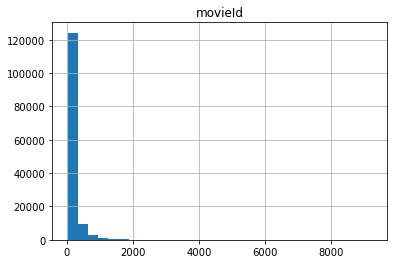

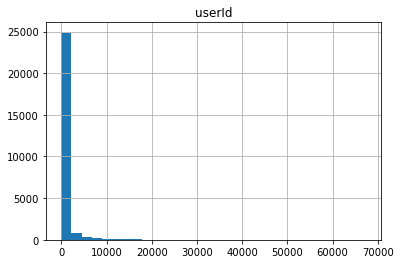

In [12]:
ratings.groupby("userId").agg({"movieId":len}).hist(bins=30)
ratings.groupby("movieId").agg({"userId":len}).hist(bins=30)
plt.show()

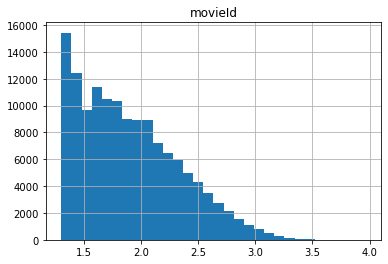

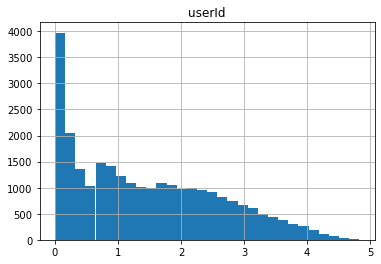

In [13]:
np.log10(ratings.groupby("userId").agg({"movieId":len})).hist(bins=30)
np.log10(ratings.groupby("movieId").agg({"userId":len})).hist(bins=30)
plt.show()

The distribution (note the log) shows that most movies are rated by a handfull of users, and that most users don't rate many movies. Furthermore, note that an user x movie matrix should contain 756 million entries, but there are only 20 million ratings. this is only ~2.6 % of non-zero entries. That is we are in a sparse situation (which is not as bad in this case as it is in some other settings)

### Exercise:
1. According to the info above, for which movies/users is easier to make recommendations? Find at least one user or movie that you suspect is troublesome.
2. The dataframe encodes part of the user-item rating matrix. Suppose that you want to write this matrix, what is the size in GB of this matrix? 